In [18]:
# importing stuff:
import numpy as np
import cte_eq
import sys
sys.path.append('./..')
import ProcessFunctions
from ProcessFunctions import find_Aisv2_onlyv
import matplotlib.pyplot as plt
from scipy.stats import shapiro



In [28]:
# load the simulation data that is recorded in RunForward2D.ipynb
# the data is saved in this directory:
drs=0.012
T_final=10500
Nx=4096
N_m_load=20
T_filter=8000 # taking T_filter large for now to see if the my idea with earthquakes works well.
# apply POD in a loop:
downsampleratio=1 # not downsampling anything
N_snapshots=0 # is not going to be used in the function
specify_N_snapshots=False
direct='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/2DSim_MainSimulation_Tf'+str(T_final)+"Nx="+str(cte_eq.Nxout)+"Nt="+str(cte_eq.Ntout)+'drs'+str(drs)+".npz"
data=np.load(direct)
v=data["v"]
theta=data["theta"]
t=data["t"]

In [29]:
# loading test data:
T_final_run = 350 # each initial condition is simulated for 250 years
coeff=1 # How the inital conditions are from the chaotic attractor
number=100
data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(30)+"coeff"+str(coeff)+"number"+str(number)+".npz"
data_smaple=np.load(data_dir)
V_ox_test=data_smaple['array1']
theta_ox_test=data_smaple['array2']
t_ox_test=data_smaple['array3']

# V_ox_test=np.log10(V_ox_test)
# theta_ox_test=np.log10(theta_ox_test)

In [30]:
V_ox_test.shape

(1250, 4096)

In [31]:
Nt=int(t.shape[0]/Nx)
print("Nt is", Nt)

Nt is 38140


In [32]:
xis=np.logspace(0,6,5)
print(xis)

[1.00000000e+00 3.16227766e+01 1.00000000e+03 3.16227766e+04
 1.00000000e+06]


In [40]:
# resmaple v based on a probability p
score=np.zeros_like(xis)
p_shapiro=np.zeros((1,N_m_load))
for index_xi,xi in enumerate(xis):

    print('xi is ', xi)
    Nt=int(t.shape[0]/Nx)
    print('total number of snapsots before filtering is ', Nt)
    t_ox=t.reshape((Nt,Nx)) 
    v_ox=v.reshape((Nt,Nx))
    theta_ox=theta.reshape((Nt,Nx))
    p=np.tanh(xi*np.max(v_ox,axis=1))
    # Generate a mask to keep rows with probability (1 - p)
    keep_mask = np.random.rand(Nt) > p  # shape: (Nt,)

    # Apply the mask
    t_resampled = t_ox[keep_mask].reshape(-1)
    v_resampled = v_ox[keep_mask].reshape(-1)
    theta_resampled=theta_ox[keep_mask].reshape(-1)
    Nt2=int(t_resampled.shape[0]/Nx)
    print('number of snapsots after filtering is', Nt2)
    v_or_theta="v"
    U_v,S_v,VT_v,q_bar_v,Nx,V_ox_filtered,theta_ox_filtered,Nt2,t_ox_filtered=ProcessFunctions.ApplyPODV_2D(v_resampled,theta_resampled,t_resampled,Nx,T_filter,v_or_theta,downsampleratio,N_snapshots,specify_N_snapshots)
    v_or_theta="theta"
    U_theta,S_theta,VT_theta,q_bar_theta,Nx,V_ox_filtered,theta_ox_filtered,Nt2,t_ox_filtered=ProcessFunctions.ApplyPODV_2D(v_resampled,theta_resampled,t_resampled,Nx,T_filter,v_or_theta,downsampleratio,N_snapshots,specify_N_snapshots)

    # check normality on the test data:
    # find p
    p_test=np.tanh(xi*np.max(V_ox_test,axis=1))
    Nt_test=p_test.shape[0]
    keep_mask_test=np.random.rand(Nt_test) > p_test
    t_resampled_test = t_ox_test[keep_mask_test]
    v_resampled_test = V_ox_test[keep_mask_test]
    theta_resampled_test=theta_ox_test[keep_mask_test]

    # apply log10 to v
    v_log10_test_filterd=np.log10(v_resampled_test)
    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox_test,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    y=A_v[1:]-A_v[:-1]
    A_v_filtered=A_v[keep_mask_test]
    y_filtered=y[keep_mask_test[:-1]]
    for i in range(N_m_load):
        stat, p_shapiro[0,i] = shapiro(A_v_filtered[:, i])
        print(f"PC {i+1}: Shapiro p-value = {p_shapiro[0,i]}")
    score[index_xi] = np.mean(np.log10(p_shapiro))

xi is  1.0
total number of snapsots before filtering is  38140
number of snapsots after filtering is 16112
PC 1: Shapiro p-value = 1.9083001152124733e-31
PC 2: Shapiro p-value = 1.1540641599006924e-24
PC 3: Shapiro p-value = 1.9672872099386118e-25
PC 4: Shapiro p-value = 3.4368886995270534e-15
PC 5: Shapiro p-value = 3.2106511226944357e-16
PC 6: Shapiro p-value = 9.653902790719064e-20
PC 7: Shapiro p-value = 1.4716252945915316e-21
PC 8: Shapiro p-value = 1.8895834739704628e-19
PC 9: Shapiro p-value = 3.6617698020765947e-25
PC 10: Shapiro p-value = 4.5431009172678424e-18
PC 11: Shapiro p-value = 1.6248368742973533e-18
PC 12: Shapiro p-value = 1.6225680467187725e-13
PC 13: Shapiro p-value = 4.3176614085253806e-13
PC 14: Shapiro p-value = 6.316674935799007e-15
PC 15: Shapiro p-value = 1.906285458954486e-25
PC 16: Shapiro p-value = 3.3514115872647474e-17
PC 17: Shapiro p-value = 9.27200453126347e-28
PC 18: Shapiro p-value = 9.626290158737524e-16
PC 19: Shapiro p-value = 1.2937268562090638e

/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


PC 1: Shapiro p-value = 1.0
PC 2: Shapiro p-value = 9.897793401264538e-18
PC 3: Shapiro p-value = 9.804526305657347e-18
PC 4: Shapiro p-value = 9.814434275034507e-18
PC 5: Shapiro p-value = 1.0098559234917896e-17
PC 6: Shapiro p-value = 1.5375540581907072e-17
PC 7: Shapiro p-value = 1.370354800204445e-17
PC 8: Shapiro p-value = 6.5040119686636e-17
PC 9: Shapiro p-value = 1.0204295251078712e-17
PC 10: Shapiro p-value = 5.2120842302868386e-17
PC 11: Shapiro p-value = 1.7577361369264e-17
PC 12: Shapiro p-value = 1.7892178038595555e-17
PC 13: Shapiro p-value = 1.8381156262411172e-16
PC 14: Shapiro p-value = 1.8595733199880083e-17
PC 15: Shapiro p-value = 5.001111815055189e-17
PC 16: Shapiro p-value = 1.900850790607262e-17
PC 17: Shapiro p-value = 2.4102431701961973e-17
PC 18: Shapiro p-value = 6.400375502333566e-17
PC 19: Shapiro p-value = 1.359408140132102e-17
PC 20: Shapiro p-value = 1.1083454238963347e-17
xi is  1000000.0
total number of snapsots before filtering is  38140
number of sna

In [41]:
p_shapiro[0,2
]

1.0

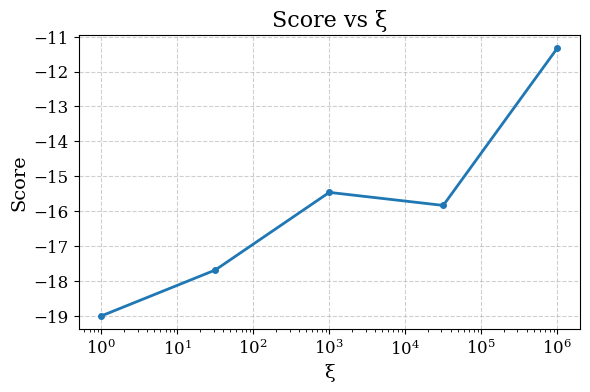

In [45]:

plt.figure(figsize=(6, 4))  # Set figure size

# Plot
plt.plot(xis, score, linewidth=2, marker='o', markersize=4)

# Labels and title
plt.xlabel('ξ', fontsize=14, fontname='DejaVu Serif')
plt.ylabel('Score', fontsize=14, fontname='DejaVu Serif')
plt.title('Score vs ξ', fontsize=16, fontname='DejaVu Serif')

# Tick parameters
plt.xticks(fontsize=12, fontname='DejaVu Serif')
plt.yticks(fontsize=12, fontname='DejaVu Serif')

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xscale("log")
plt.show()

In [27]:
p.shape

(38140,)